In [61]:
!pip install labelme tensorflow tensorflow-gpu opencv-python matplotlib albumentations

  Using cached tensorflow-gpu-2.12.0.tar.gz (2.6 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Running setup.py clean for tensorflow-gpu
Failed to build tensorflow-gpu
  Running setup.py install for tensorflow-gpu: started
  Running setup.py install for tensorflow-gpu: finished with status 'error'


  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> [18 lines of output]
      Traceback (most recent call last):
        File "<string>", line 2, in <module>
        File "<pip-setuptools-caller>", line 34, in <module>
        File "C:\Users\nawil\AppData\Local\Temp\pip-install-xoitoer9\tensorflow-gpu_4825d60a1c1d4ff2805e6b34637abe6a\setup.py", line 37, in <module>
          raise Exception(TF_REMOVAL_WARNING)
      Exception:
      
      The "tensorflow-gpu" package has been removed!
      
      Please install "tensorflow" instead.
      
      Other than the name, the two packages have been identical
      since TensorFlow 2.1, or roughly since Sep 2019. For more
      information, see: pypi.org/project/tensorflow-gpu
      
      
      [end of output]
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for tensorflow-gpu
  error: subprocess-e

https://github.com/nicknochnack/FaceDetection/blob/main/FaceDetection.ipynb

In [1]:
import os
import time
import uuid
import cv2

In [2]:
IMAGES_PATH = os.path.join('data', 'images')
number_images = 30

In [6]:
cap = cv2.VideoCapture(0)
if not cap.isOpened():
    print('cant open cam')
    exit()
for imgnum in range(number_images):
    print('Collecting image {}'.format(imgnum))
    ret, frame = cap.read()
    while ret == False:
        print("retrying frame")
        cap.release()
        cap = cv2.VideoCapture(0)
        ret, frame = cap.read()
    imgname = os.path.join(IMAGES_PATH,f'{str(uuid.uuid1())}.jpg')
    cv2.imwrite(imgname, frame)
    #cv2.imshow('frame', frame)
    time.sleep(0.5)

    if cv2.waitKey(0) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

In [8]:
!labelme

In [10]:
120 *.7 #84 for train


84.0

In [11]:
120 * .15 #18 for test and val

18.0

In [18]:
import tensorflow as tf
import json
import numpy as np
from matplotlib import pyplot as plt

In [9]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [8]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [33]:
images = tf.data.Dataset.list_files('data\\images\\*.jpg', shuffle=False)
#images.as_numpy_iterator().next()


InvalidArgumentError: Expected 'tf.Tensor(False, shape=(), dtype=bool)' to be true. Summarized data: b'No files matched pattern: data\\images\\*.jpg'

In [34]:

def load_image(x):
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img


In [ ]:

images = images.map(load_image)
#images.as_numpy_iterator().next()

type(images)

In [42]:
image_generator = images.batch(4).as_numpy_iterator()

In [53]:
plot_images = image_generator.next()

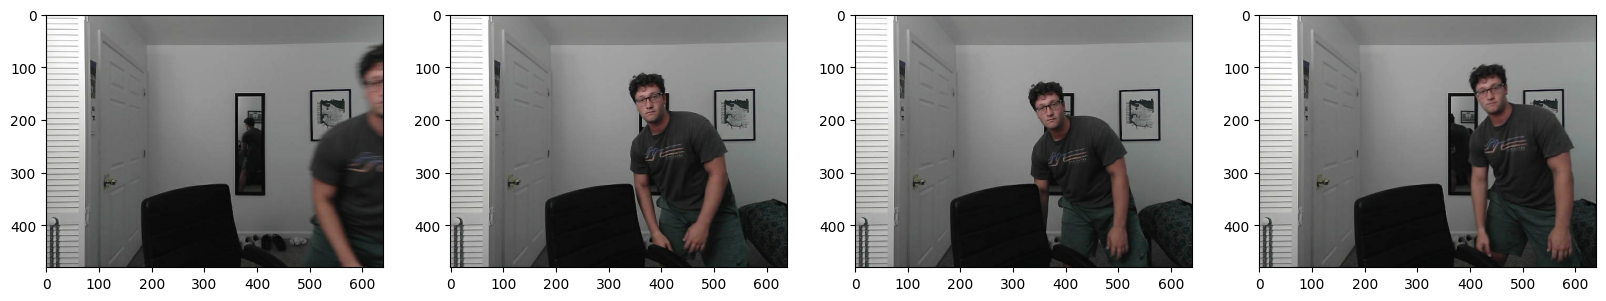

In [54]:
fig, ax = plt.subplots(ncols=4, figsize =(20,20))
for idx, image in enumerate(plot_images):
    ax[idx].imshow(image)
plt.show()

In [12]:
for folder in ['train', 'test', 'val']:
    for file in os.listdir(os.path.join('data', folder, 'images')):
        filename = file.split('.')[0]+'.json'
        existing_filepath = os.path.join('data', 'labels', filename)
        if os.path.exists(existing_filepath):
            new_filepath = os.path.join('data', folder, 'labels', filename)
            os.replace(existing_filepath, new_filepath)

Start Augmenting

In [13]:
import albumentations as alb

In [14]:
augmentor= alb.Compose([alb.RandomCrop(width=450, height=450),
                        alb.HorizontalFlip(p=0.5),
                        alb.RandomBrightnessContrast(p=0.2),
                        alb.RandomGamma(p=0.2),
                        alb.RGBShift(p=0.2),
                        alb.VerticalFlip(p=0.5)],
                        bbox_params=alb.BboxParams(format='albumentations', label_fields=['class_labels']))

In [16]:
img = cv2.imread(os.path.join('data','train', 'images', '7f940a20-fbda-11ed-afba-8cb87e55bbac.jpg'))

In [19]:
with open(os.path.join('data', 'train', 'labels', '7f940a20-fbda-11ed-afba-8cb87e55bbac.json'), 'r') as f:
    label = json.load(f)

In [20]:
label['shapes'][0]

{'label': 'face',
 'points': [[428.6734693877552, 163.97959183673467],
  [521.530612244898, 298.67346938775506]],
 'group_id': None,
 'description': '',
 'shape_type': 'rectangle',
 'flags': {}}

In [21]:
coords = [0,0,0,0]
coords[0] = label['shapes'][0]['points'][0][0]
coords[1] = label['shapes'][0]['points'][0][1]
coords[2] = label['shapes'][0]['points'][1][0]
coords[3] = label['shapes'][0]['points'][1][1]

In [23]:
coords = list(np.divide(coords, [640,480,640,480]))

In [24]:
coords

[0.6698022959183675,
 0.3416241496598639,
 0.8148915816326531,
 0.6222363945578231]

In [26]:
augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])

In [29]:
augmented['bboxes']

[(0.7281632653061226,
  0.34884353741496593,
  0.9345124716553288,
  0.6481632653061223)]

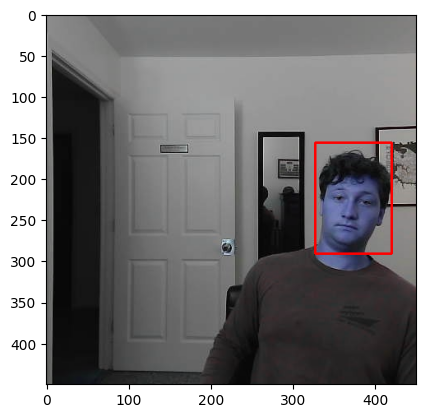

In [30]:
cv2.rectangle(augmented['image'], 
              tuple(np.multiply(augmented['bboxes'][0][:2], [450,450]).astype(int)),
              tuple(np.multiply(augmented['bboxes'][0][2:], [450,450]).astype(int)), 
                    (255,0,0), 2)

plt.imshow(augmented['image'])

Build and run Augmentation Pipeline

In [31]:
for partition in ['train','test','val']: 
    for image in os.listdir(os.path.join('data', partition, 'images')):
        img = cv2.imread(os.path.join('data', partition, 'images', image))

        coords = [0,0,0.00001,0.00001]
        label_path = os.path.join('data', partition, 'labels', f'{image.split(".")[0]}.json')
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)

            coords[0] = label['shapes'][0]['points'][0][0]
            coords[1] = label['shapes'][0]['points'][0][1]
            coords[2] = label['shapes'][0]['points'][1][0]
            coords[3] = label['shapes'][0]['points'][1][1]
            coords = list(np.divide(coords, [640,480,640,480]))

        try: 
            for x in range(60):
                augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])
                cv2.imwrite(os.path.join('aug_data', partition, 'images', f'{image.split(".")[0]}.{x}.jpg'), augmented['image'])

                annotation = {}
                annotation['image'] = image

                if os.path.exists(label_path):
                    if len(augmented['bboxes']) == 0: 
                        annotation['bbox'] = [0,0,0,0]
                        annotation['class'] = 0 
                    else: 
                        annotation['bbox'] = augmented['bboxes'][0]
                        annotation['class'] = 1
                else: 
                    annotation['bbox'] = [0,0,0,0]
                    annotation['class'] = 0 


                with open(os.path.join('aug_data', partition, 'labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                    json.dump(annotation, f)

        except Exception as e:
            print(e)

load augmented images into tensorflow dataset

In [35]:
train_images = tf.data.Dataset.list_files('aug_data\\train\\images\\*.jpg', shuffle=False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (120,120)))
train_images = train_images.map(lambda x: x/255)

In [36]:
test_images = tf.data.Dataset.list_files('aug_data\\test\\images\\*.jpg', shuffle=False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (120,120)))
test_images = test_images.map(lambda x: x/255)

In [37]:
val_images = tf.data.Dataset.list_files('aug_data\\test\\images\\*.jpg', shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (120,120)))
val_images = val_images.map(lambda x: x/255)

In [38]:
train_images.as_numpy_iterator().next()

array([[[0.18033089, 0.20208333, 0.23143382],
        [0.1627451 , 0.17696078, 0.21029411],
        [0.15833333, 0.16979167, 0.20343137],
        ...,
        [0.053125  , 0.06881128, 0.06488971],
        [0.08792892, 0.10361519, 0.09969363],
        [0.05784314, 0.07659314, 0.07113971]],

       [[0.19528186, 0.19822304, 0.21832108],
        [0.17598039, 0.17990196, 0.1995098 ],
        [0.16862746, 0.17254902, 0.18866421],
        ...,
        [0.05171569, 0.05955882, 0.05563726],
        [0.05674019, 0.06458333, 0.06066176],
        [0.08707108, 0.09454657, 0.09080882]],

       [[0.1985294 , 0.19460784, 0.22598039],
        [0.17984068, 0.17689951, 0.20680147],
        [0.16862746, 0.17254902, 0.19172794],
        ...,
        [0.03976716, 0.04761029, 0.04368873],
        [0.05790441, 0.06574755, 0.06182598],
        [0.10637255, 0.11384804, 0.1101103 ]],

       ...,

       [[0.39460784, 0.42892158, 0.43529412],
        [0.3882353 , 0.42745098, 0.43137255],
        [0.39258578, 0

Prepare labels

In [39]:
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding = "utf-8") as f:
        label = json.load(f)
    
    return [label['class']], label['bbox']

load labels to TF dataset

In [40]:
train_labels = tf.data.Dataset.list_files('aug_data\\train\\labels\\*.json', shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [41]:
test_labels = tf.data.Dataset.list_files('aug_data\\test\\labels\\*.json', shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [42]:
val_labels = tf.data.Dataset.list_files('aug_data\\val\\labels\\*.json', shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

combine label and image samples

In [43]:
len(train_images), len(train_labels), len(test_images), len(test_labels), len(val_images), len(val_labels)

(5040, 5040, 1080, 1080, 1080, 1080)

In [44]:
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(6000)
train = train.batch(8)
train = train.prefetch(4)

In [45]:
test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(1400)
test = test.batch(8)
test = test.prefetch(4)

In [46]:
val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(1400)
val = val.batch(8)
val = val.prefetch(4)

In [49]:
train.as_numpy_iterator().next()[1]

(array([[0],
        [0],
        [0],
        [0],
        [1],
        [1],
        [1],
        [1]], dtype=uint8),
 array([[0.      , 0.      , 0.      , 0.      ],
        [0.      , 0.      , 0.      , 0.      ],
        [0.      , 0.      , 0.      , 0.      ],
        [0.      , 0.      , 0.      , 0.      ],
        [0.3245  , 0.5557  , 0.4717  , 0.721   ],
        [0.439   , 0.188   , 0.5864  , 0.349   ],
        [0.1515  , 0.002222, 0.547   , 0.4824  ],
        [0.      , 0.1707  , 0.11993 , 0.309   ]], dtype=float16))

In [50]:
data_samples = train.as_numpy_iterator()

In [53]:
res = data_samples.next()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


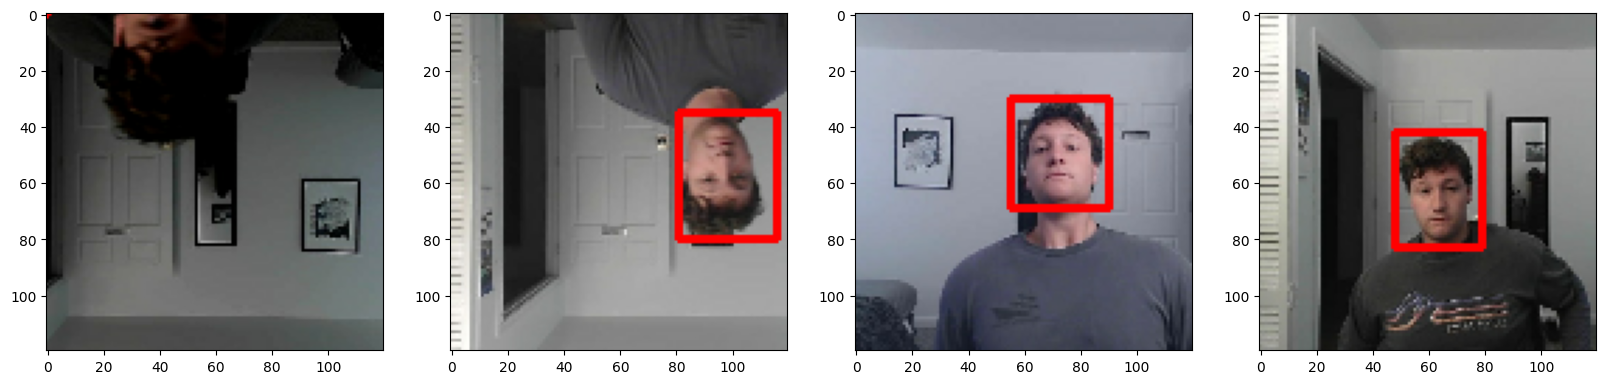

In [54]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = res[0][idx]
    sample_coords = res[1][1][idx]
    
    cv2.rectangle(sample_image, 
                  tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                  tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                        (255,0,0), 2)

    ax[idx].imshow(sample_image)

Build deeplearning with functional api

import layers and base network

In [55]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16

In [56]:
vgg = VGG16(include_top=False)

58889256/58889256 [==============================] - 1s 0us/step


In [57]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

build instance of network

In [58]:
def build_model(): 
    input_layer = Input(shape=(120,120,3))
    
    vgg = VGG16(include_top=False)(input_layer)

    # Classification Model  
    f1 = GlobalMaxPooling2D()(vgg)
    class1 = Dense(2048, activation='relu')(f1)
    class2 = Dense(1, activation='sigmoid')(class1)
    
    # Bounding box model
    f2 = GlobalMaxPooling2D()(vgg)
    regress1 = Dense(2048, activation='relu')(f2)
    regress2 = Dense(4, activation='sigmoid')(regress1)
    
    facetracker = Model(inputs=input_layer, outputs=[class2, regress2])
    return facetracker

testing out neural network with instance

In [59]:
facetracker = build_model()

In [60]:
facetracker.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 120, 120, 3  0           []                               
                                )]                                                                
                                                                                                  
 vgg16 (Functional)             (None, None, None,   14714688    ['input_2[0][0]']                
                                512)                                                              
                                                                                                  
 global_max_pooling2d (GlobalMa  (None, 512)         0           ['vgg16[0][0]']                  
 xPooling2D)                                                                                  

In [61]:
X, y = train.as_numpy_iterator().next()

In [62]:
X.shape

(8, 120, 120, 3)

In [63]:
classes, coords = facetracker.predict(X)

1/1 [==============================] - 0s 487ms/step


In [64]:
classes, coords

(array([[0.4626728 ],
        [0.50737375],
        [0.52040446],
        [0.528507  ],
        [0.508278  ],
        [0.47205958],
        [0.6397856 ],
        [0.5144139 ]], dtype=float32),
 array([[0.5980935 , 0.28114185, 0.481103  , 0.7189453 ],
        [0.60161066, 0.29382175, 0.48853004, 0.66213274],
        [0.56672883, 0.32561275, 0.49587452, 0.6637453 ],
        [0.6366774 , 0.33126423, 0.50136423, 0.6563181 ],
        [0.6047164 , 0.30042654, 0.5283958 , 0.6803676 ],
        [0.5547163 , 0.29789278, 0.51188666, 0.61314934],
        [0.5155    , 0.26542467, 0.40394577, 0.7142025 ],
        [0.58744776, 0.26021862, 0.52565724, 0.7625992 ]], dtype=float32))

Define Losses and Optimizers

define optimizer and lr

In [65]:
batches_per_epoch = len(train)
lr_decay = (1./0.75 -1)/batches_per_epoch

In [66]:
opt = tf.keras.optimizers.Adam(learning_rate = 0.0001, decay = lr_decay)

create localization loss and classification loss

In [67]:
def localization_loss(y_true, yhat):            
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2]))
                  
    h_true = y_true[:,3] - y_true[:,1] 
    w_true = y_true[:,2] - y_true[:,0] 

    h_pred = yhat[:,3] - yhat[:,1] 
    w_pred = yhat[:,2] - yhat[:,0] 
    
    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true-h_pred))
    
    return delta_coord + delta_size

In [68]:
classloss = tf.keras.losses.BinaryCrossentropy()
regressloss = localization_loss

train neural network

Create Custom model class

In [69]:
class FaceTracker(Model): 
    def __init__(self, eyetracker,  **kwargs): 
        super().__init__(**kwargs)
        self.model = eyetracker

    def compile(self, opt, classloss, localizationloss, **kwargs):
        super().compile(**kwargs)
        self.closs = classloss
        self.lloss = localizationloss
        self.opt = opt
    
    def train_step(self, batch, **kwargs): 
        
        X, y = batch
        
        with tf.GradientTape() as tape: 
            classes, coords = self.model(X, training=True)
            
            batch_classloss = self.closs(y[0], classes)
            batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
            
            total_loss = batch_localizationloss+0.5*batch_classloss
            
            grad = tape.gradient(total_loss, self.model.trainable_variables)
        
        opt.apply_gradients(zip(grad, self.model.trainable_variables))
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
    
    def test_step(self, batch, **kwargs): 
        X, y = batch
        
        classes, coords = self.model(X, training=False)
        
        batch_classloss = self.closs(y[0], classes)
        batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
        total_loss = batch_localizationloss+0.5*batch_classloss
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
        
    def call(self, X, **kwargs): 
        return self.model(X, **kwargs)

In [70]:
model = FaceTracker(facetracker)
model.compile(opt, classloss, regressloss)

train

In [71]:
logdir = 'logs'

In [72]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [76]:
hist = model.fit(train, epochs=40, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/40
630/630 [==============================] - 19s 23ms/step - total_loss: 0.0023 - class_loss: 1.6287e-04 - regress_loss: 0.0022 - val_total_loss: 4.8611 - val_class_loss: 3.8100 - val_regress_loss: 2.9561
Epoch 2/40
630/630 [==============================] - 18s 23ms/step - total_loss: 0.0016 - class_loss: 3.3026e-05 - regress_loss: 0.0016 - val_total_loss: 6.7113 - val_class_loss: 5.4272 - val_regress_loss: 3.9976
Epoch 3/40
630/630 [==============================] - 18s 23ms/step - total_loss: 0.0016 - class_loss: 2.2364e-05 - regress_loss: 0.0016 - val_total_loss: 4.4398 - val_class_loss: 3.6103 - val_regress_loss: 2.6346
Epoch 4/40
630/630 [==============================] - 18s 23ms/step - total_loss: 0.0015 - class_loss: 1.6532e-05 - regress_loss: 0.0014 - val_total_loss: 4.0574 - val_class_loss: 3.4664 - val_regress_loss: 2.3242
Epoch 5/40
630/630 [==============================] - 18s 23ms/step - total_loss: 0.0013 - class_loss: 1.2603e-05 - regress_loss: 0.0013 - val_t

plot performance

In [77]:
hist.history

{'total_loss': [0.001938431872986257,
  0.0004468752595130354,
  0.0014340264024212956,
  0.0007122957031242549,
  0.00062356679700315,
  0.0006794838700443506,
  0.002989178989082575,
  0.0009969333186745644,
  0.0018685582326725125,
  0.0008345450041815639,
  0.001439795596525073,
  0.0003280328237451613,
  0.00043486300273798406,
  0.0008513551438227296,
  0.0008105256129056215,
  0.0012920363806188107,
  0.000492408056743443,
  0.00021317630307748914,
  0.0006008815253153443,
  0.0004849511315114796,
  0.00030144897755235434,
  0.00018705766706261784,
  0.0007542702369391918,
  0.0002407743304502219,
  0.0002647154324222356,
  0.00014639079745393246,
  0.0005999779677949846,
  0.00010907719115493819,
  0.0001615995424799621,
  0.0002322275540791452,
  0.00022520520724356174,
  7.569126319140196e-05,
  0.00021335843484848738,
  0.00011480467219371349,
  0.0004198178357910365,
  0.000140816206112504,
  0.00013246326125226915,
  0.00019548533600755036,
  9.967971709556878e-05,
  7.428

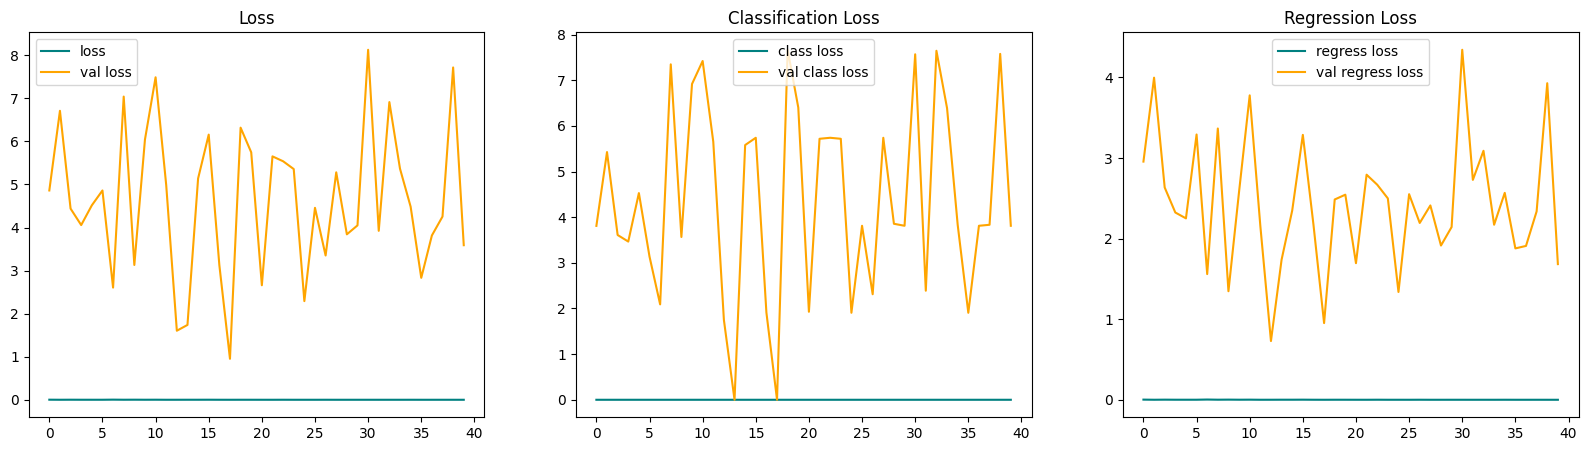

In [78]:
fig, ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(hist.history['total_loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_total_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(hist.history['class_loss'], color='teal', label='class loss')
ax[1].plot(hist.history['val_class_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Classification Loss')
ax[1].legend()

ax[2].plot(hist.history['regress_loss'], color='teal', label='regress loss')
ax[2].plot(hist.history['val_regress_loss'], color='orange', label='val regress loss')
ax[2].title.set_text('Regression Loss')
ax[2].legend()

plt.show()

Make predictions

In [92]:
test_data = test.as_numpy_iterator()

In [105]:
test_sample = test_data.next()

In [106]:
yhat = facetracker.predict(test_sample[0])

1/1 [==============================] - 0s 12ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


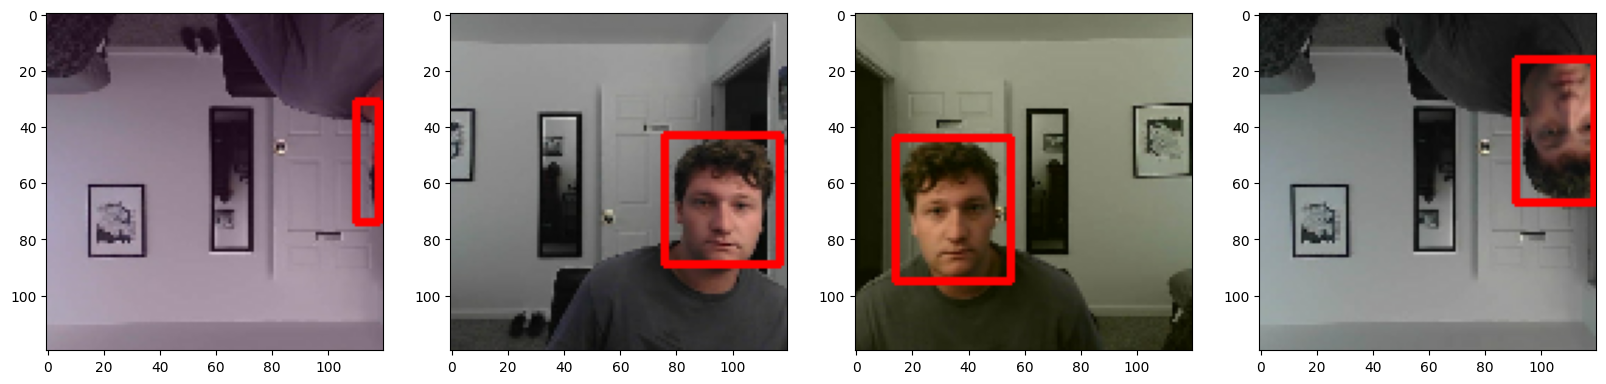

In [107]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = test_sample[0][idx]
    sample_coords = yhat[1][idx]
    
    if yhat[0][idx] > 0.9:
        cv2.rectangle(sample_image, 
                      tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                            (255,0,0), 2)
    
    ax[idx].imshow(sample_image)

Save the Model

In [96]:
from tensorflow.keras.models import load_model

In [97]:
facetracker.save('facetracker.h5')

In [98]:
facetracker = load_model('facetracker.h5')

In [109]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    _ , frame = cap.read()
    frame = frame[50:500, 50:500,:]
    
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    resized = tf.image.resize(rgb, (120,120))
    
    yhat = facetracker.predict(np.expand_dims(resized/255,0))
    sample_coords = yhat[1][0]
    
    if yhat[0] > 0.5: 
        # Controls the main rectangle
        cv2.rectangle(frame, 
                      tuple(np.multiply(sample_coords[:2], [450,450]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [450,450]).astype(int)), 
                            (255,0,0), 2)
        # Controls the label rectangle
        cv2.rectangle(frame, 
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int), 
                                    [0,-30])),
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                    [80,0])), 
                            (255,0,0), -1)
        
        # Controls the text rendered
        cv2.putText(frame, 'face', tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                               [0,-5])),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
    
    cv2.imshow('EyeTrack', frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 13ms/step


KeyboardInterrupt: 